### This notebook trains a neural network to classify a timeseries as either stable or unstable

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

Using the logistic equation to generate timeseries data

In [2]:
def logisticEq(r, x0, N):
    x = [x0]
    for i in range(1, N):
        x_new = r * x[i-1] * (1 - x[i-1])
        x.append(x_new)
    return np.array(x)

Generate the sample data. With the logistic growth equation, we will generate one chaotic timeseries (r=4) and one stable timeseries (r=3.5)

In [3]:
samples = np.arange(0, 10000)

r1 = 3.5
r2 = 4
x0 = 0.3
N = len(samples)

y1 = logisticEq(r=r1, x0=x0, N = N) * 5
y1 = np.expand_dims(y1, axis=1) # add dimension to define 1D data

y2 = logisticEq(r=r2, x0=x0, N = N) * 5
y2 = np.expand_dims(y2, axis=1) # add dimension to define 1D data

Functions to embed the data and plot for visualization of the phase portrait

In [4]:
def TDE(x, m, tau):
    emb = np.zeros((len(x)-m*tau, m))
    for i in range(m):
        emb[:,i] = x[i*tau:(i*tau + (len(x)-m*tau))]
    return emb

In [5]:
def statespaceplot(x, title):
    fig = plt.figure()
    fig.set_size_inches(8, 10)
    if x.shape[1] > 2:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], alpha=0.7)
    else:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("X'")
    ax.set_zlabel('X"')
    plt.show()

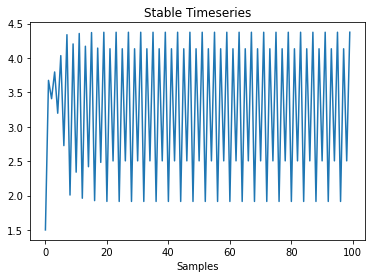

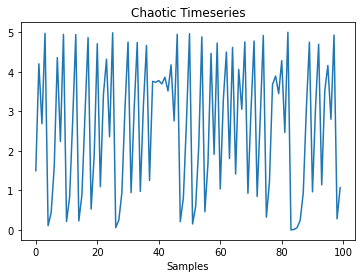

In [8]:
plt.plot(samples[:100], y1[:100])
plt.xlabel("Samples")
plt.title("Stable Timeseries")
plt.show()

plt.plot(samples[:100], y2[:100])
plt.xlabel("Samples")
plt.title("Chaotic Timeseries")
plt.show()

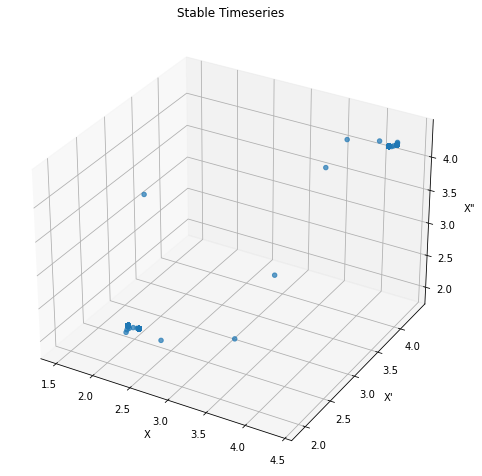

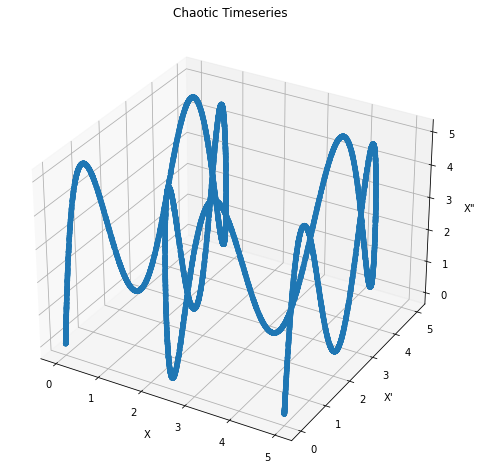

In [9]:
y1_tde_data = TDE(y1.squeeze(), m=3, tau=2)
statespaceplot(y1_tde_data, "Stable Timeseries")

y2_tde_data = TDE(y2.squeeze(), m=3, tau=2)
statespaceplot(y2_tde_data, "Chaotic Timeseries")

To prevent vanishing/expoding gradients we scale the data before into the network. StandardScaler (x - mean / std) or MinMaxScaler ((x - min) / (max - min)) work well. This is crucial for multivariate datasets.
  
We are using MinMaxScaler 

In [10]:
scaler = MinMaxScaler()
scaled_y1 = scaler.fit_transform(y1)
scaled_y2 = scaler.transform(y2)

"createsequence" is a function to window the data to create model inputs with a corresponding label 

In [11]:
def createsequences(data, label, window_size=32):
    x = []
    y = []
    for i in range(window_size, data.shape[0]):
        x.append(data[i-window_size:i])
        y.append(label)

    return np.array(x), np.array(y)

Window the data and use an numeric label of 0 for stable data and 1 for unstable timeseries

In [12]:
stable_x, stable_y = createsequences(scaled_y1, label=0)
unstable_x, unstable_y = createsequences(scaled_y2, label=1)

x_data = np.concatenate([stable_x, unstable_x], axis=0)
y_data = np.concatenate([stable_y, unstable_y], axis=0)

x_data, y_data = shuffle(x_data, y_data)

In [13]:
# check number of labels in our training outputs
len(np.unique(y_data))

2

Split the data into training and validation

In [15]:
cutoff = round(0.8 * x_data.shape[0])

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_val = x_data[cutoff:]
y_val = y_data[cutoff:]

print("Training Inputs Shape:", x_train.shape)
print("Training Outputs Shape:", y_train.shape)

print("\nValidation Inputs Shape:", x_val.shape)
print("Validation Outputs Shape:", y_val.shape)

Training Inputs Shape: (15949, 32, 1)
Training Outputs Shape: (15949,)

Validation Inputs Shape: (3987, 32, 1)
Validation Outputs Shape: (3987,)


Put data into a tensorflow dataset. I need to do this when I don't have enough RAM on my machine
This is not necessary, just will come in handy one day.

In [16]:
batch_size = 32
shuffle_buffer_size = 1000

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(batch_size=batch_size)
train_ds = train_ds.shuffle(shuffle_buffer_size).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size=batch_size)
val_ds = val_ds.shuffle(shuffle_buffer_size).prefetch(1)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-25 00:54:31.382195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-25 00:54:31.383148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Create a LSTM Model. Note that the sigmoid activation is added to the output layer for the binary classification problem.

In [17]:
inputs = Input(shape=(None, 1))

h = LSTM(16, return_sequences=True)(inputs)
h = LSTM(16, return_sequences=False)(h)

outputs = Dense(1, activation='sigmoid')(h)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Compile and train the model. Use binary crossentropy loss for our classification problem

In [19]:
optimizer = Adam(learning_rate=1e-3)
metrics = 'acc'
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [60]:
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=20,
            shuffle=True,
            batch_size=32,
            verbose=1)

Epoch 1/20


2023-01-24 21:37:15.466833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:37:15.797268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:37:15.860057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:37:15.952588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/499 [..............................] - ETA: 14s - loss: 0.6728 - acc: 0.5521  

2023-01-24 21:37:16.058283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - ETA: 0s - loss: 0.1396 - acc: 0.9423

2023-01-24 21:37:27.164257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:37:27.283717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:37:27.337107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 15s 25ms/step - loss: 0.1396 - acc: 0.9423 - val_loss: 0.0325 - val_acc: 0.9940
Epoch 2/20
499/499 [==============================] - 11s 23ms/step - loss: 0.0405 - acc: 0.9912 - val_loss: 0.0331 - val_acc: 0.9920
Epoch 3/20
499/499 [==============================] - 11s 22ms/step - loss: 0.0295 - acc: 0.9932 - val_loss: 0.0267 - val_acc: 0.9932
Epoch 4/20
499/499 [==============================] - 11s 22ms/step - loss: 0.0292 - acc: 0.9932 - val_loss: 0.0222 - val_acc: 0.9942
Epoch 5/20
499/499 [==============================] - 11s 23ms/step - loss: 0.0145 - acc: 0.9969 - val_loss: 0.0216 - val_acc: 0.9945
Epoch 6/20
499/499 [==============================] - 11s 23ms/step - loss: 0.0154 - acc: 0.9967 - val_loss: 0.0126 - val_acc: 0.9972
Epoch 7/20
499/499 [==============================] - 11s 23ms/step - loss: 0.0125 - acc: 0.9974 - val_loss: 0.0183 - val_acc: 0.9955
Epoch 8/20
499/499 [==============================] - 12s 24ms/step - los

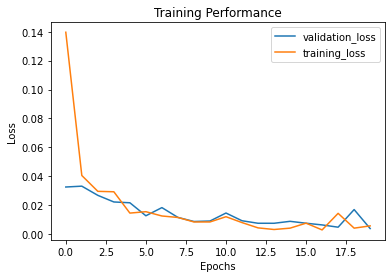

In [61]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate the validation dataset

In [65]:
y_pred = model.predict(x_val, batch_size=32)

2023-01-24 21:42:27.685675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:42:27.855691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:42:27.961910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
# Raw outputs for the model predictions
print(y_pred)

NameError: name 'y_pred' is not defined

The model outputs values on a scale from 0 to 1. It is necessary to threshold these values and assign a classification value ( 0 or 1 ). I'm using 0.5 as my threshold.

In [71]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(y_pred)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


Evaluate the accuracy of our model's prediction on the validation data

In [73]:
accuracy = metrics.accuracy_score(y_val, y_pred) * 100
print(accuracy)

99.899673940306
